In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV
from tqdm import tqdm
from utils import LoadRumoursDataset,LoadRumoursDatasetFilterNode
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import matplotlib.pylab as plt
from sklearn.metrics import *
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
import uuid

In [3]:
#
file_path_replies = r"/home/azureuser/rumour-detection-pheme/replies_charlie_hebdo.pkl"
file_path_posts = r"/home/azureuser/rumour-detection-pheme/posts_charlie_hebdo.pkl"


### SMOTE APPROACH

In [4]:
time_cut =(24*60*3)
processor = LoadRumoursDatasetFilterNode(file_path_replies, file_path_posts, time_cut)
processor.load_data()
processor.process_data()
df_final = processor.get_final_dataframe()

In [5]:
X  = df_final.drop(columns=['rumour'])
X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
#X = np.hstack([X.drop(columns=['embeddings_avg']).values, np.array(pd.DataFrame(X.embeddings_avg.tolist()))])
y =df_final['rumour']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y,shuffle=True
)

In [6]:
print(y_train.sum(),y_train.shape)

357 (1601,)


In [7]:
print(y_test.sum(),y_test.shape)

90 (401,)


In [8]:
# Apply SMOTE to the features without embeddings
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42,sampling_strategy='minority')
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [9]:

# Define the parameter grid to search
param_dist = {
    'n_estimators': [100, 200, 400, 500],  # Number of trees
    'max_depth': [None, 10, 20, 30, 40, 50],  # Maximum depth of each tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],  # Minimum number of samples required at a leaf node
    'max_features': ['sqrt', 'log2', None],  # Number of features to consider for the best split
    'bootstrap': [True, False],  # Whether to bootstrap samples when building trees
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier()

# Use RandomizedSearchCV to search the parameter space
random_search_rf = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,  # Number of different combinations to try
    scoring='recall',  # F1 score for imbalanced classification
    cv=5,  # 5-fold cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)



In [10]:
# Fit the random search model
random_search_rf.fit(X_resampled, y_resampled)

# Print the best parameters and the corresponding score
print("Best parameters found: ", random_search_rf.best_params_)
print("Best Recall: ", random_search_rf.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best parameters found:  {'n_estimators': 400, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 50, 'bootstrap': False}
Best Recall:  0.9485587511335666


In [12]:
best_params =  random_search_rf.best_params_

In [13]:
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

def modelfit(alg, X_train, y_train, X_test, y_test, performCV=True, printFeatureImportance=True, cv_folds=5):
    # Fit the algorithm on the data
    #alg.fit(X_train, y_train)
        
    # Predict training set:
    dtrain_predictions = alg.predict(X_train)
    dtrain_predprob = alg.predict_proba(X_train)[:,1]

    # Predict test set:
    dtest_predictions = alg.predict(X_test)
    dtest_predprob = alg.predict_proba(X_test)[:,1]
    
    # Perform cross-validation:
    if performCV:
        cv_score = cross_val_score(alg, X_train, y_train, cv=cv_folds, scoring='recall')
    
    # Print model report for Train:
    print("\nModel Report Train")
    print("AUC Score : %f" % roc_auc_score(y_train, dtrain_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_train, dtrain_predictions))
    print("Precision : %.4g" % precision_score(y_train, dtrain_predictions))
    print("Recall : %f" % recall_score(y_train, dtrain_predictions))
    
    # Plot confusion matrix for Train
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    sns.heatmap(confusion_matrix(y_train, dtrain_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Train")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    # Print model report for Test:
    print("\nModel Report Test")
    print("AUC Score : %f" % roc_auc_score(y_test, dtest_predprob))
    print("Accuracy : %.4g" % accuracy_score(y_test, dtest_predictions))
    print("Precision : %.4g" % precision_score(y_test, dtest_predictions))
    print("Recall : %f" % recall_score(y_test, dtest_predictions))
    
    # Plot confusion matrix for Test
    plt.subplot(1, 2, 2)
    sns.heatmap(confusion_matrix(y_test, dtest_predictions), annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix - Test")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    
    plt.tight_layout()
    plt.show()
    
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score), np.std(cv_score), np.min(cv_score), np.max(cv_score)))

    return alg



In [14]:
# Train the final model with the best hyperparameters
final_model = RandomForestClassifier(
    **best_params
)
final_model.fit(X_resampled, y_resampled)


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, n_estimators=400)


Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.911218
Accuracy : 0.8529
Precision : 0.6598
Recall : 0.711111


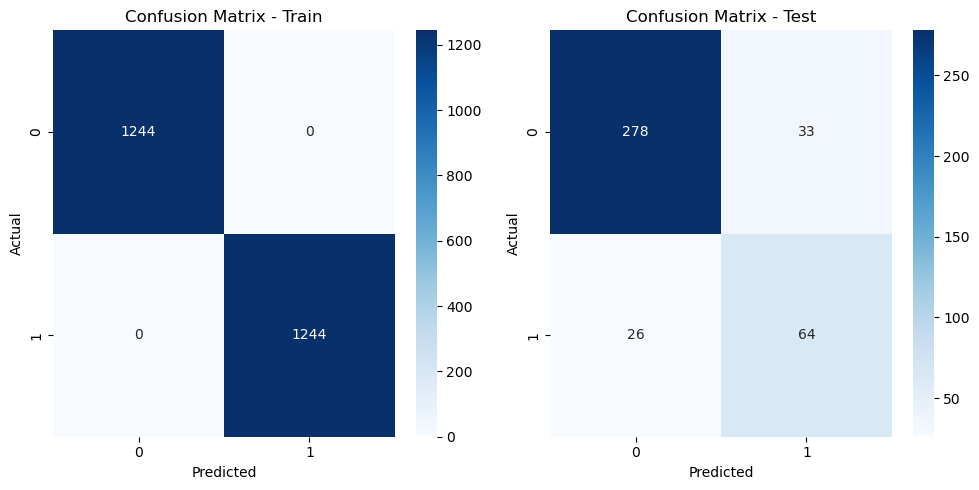

CV Score : Mean - 0.9461491 | Std - 0.0320777 | Min - 0.8875502 | Max - 0.9839357


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, n_estimators=400)

In [15]:
modelfit(final_model,X_resampled, y_resampled,X_test,y_test)


Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.911218
Accuracy : 0.8529
Precision : 0.6598
Recall : 0.711111


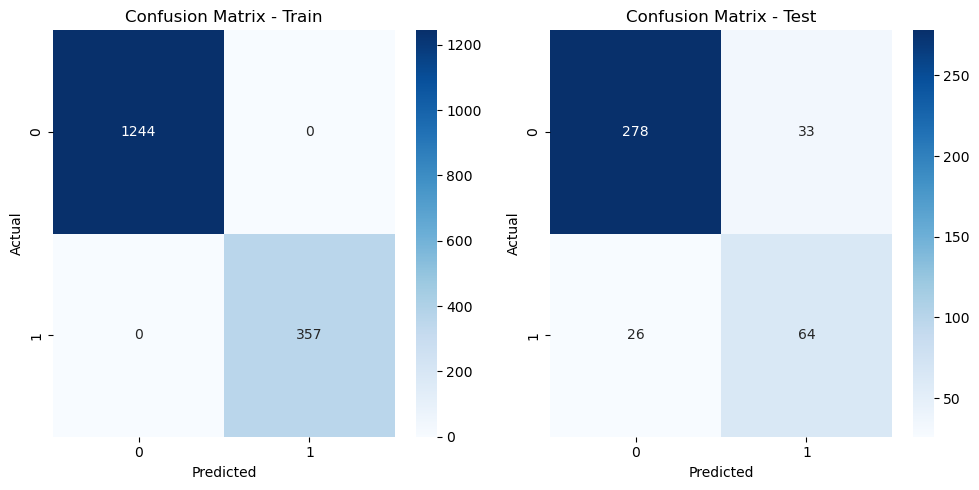

CV Score : Mean - 0.5880673 | Std - 0.03102689 | Min - 0.5352113 | Max - 0.625


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, n_estimators=400)

In [16]:
modelfit(final_model,X_train, y_train,X_test,y_test)

#### Without SMOTE

In [17]:
# Fit the RandomizedSearchCV object to the training data
random_search.fit(X_train, y_train)

# Print the best set of hyperparameters and the corresponding score
print("Best set of hyperparameters: ", random_search.best_params_)
print("Best score: ", random_search.best_score_)

NameError: name 'random_search' is not defined


Model Report Train
AUC Score : 1.000000
Accuracy : 1
Precision : 1
Recall : 1.000000

Model Report Test
AUC Score : 0.911218
Accuracy : 0.8529
Precision : 0.6598
Recall : 0.711111


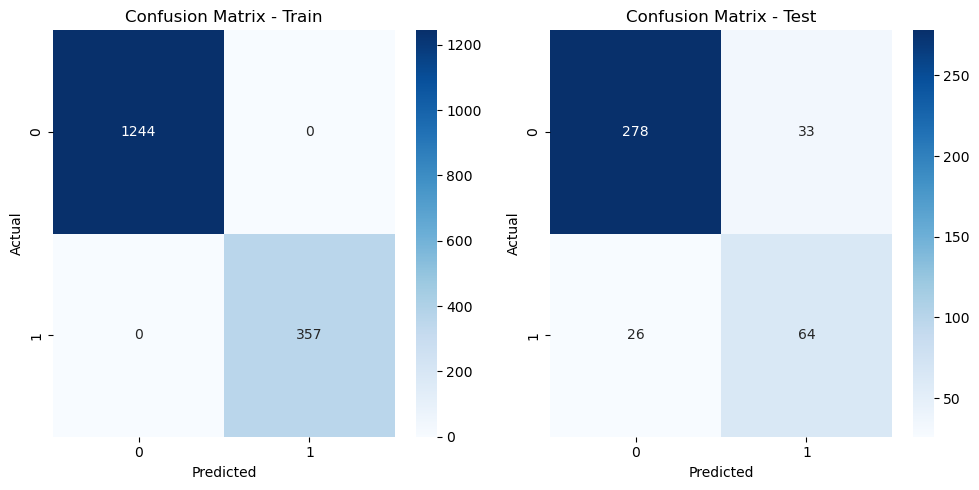

CV Score : Mean - 0.5937011 | Std - 0.02977306 | Min - 0.5492958 | Max - 0.6388889


RandomForestClassifier(bootstrap=False, max_depth=50, max_features='log2',
                       min_samples_leaf=2, n_estimators=400)

In [18]:
modelfit(final_model, X_train, y_train,X_test,y_test)

#### SMOTE and generic Random Forest pipeline

In [21]:

# Define the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,      # Number of trees in the forest
    max_depth=5
)


In [22]:
rf_model.fit(X_resampled, y_resampled)

RandomForestClassifier(max_depth=5)


Model Report Train
AUC Score : 0.960998
Accuracy : 0.8844
Precision : 0.6784
Recall : 0.915966

Model Report Test
AUC Score : 0.896249
Accuracy : 0.8155
Precision : 0.558
Recall : 0.855556


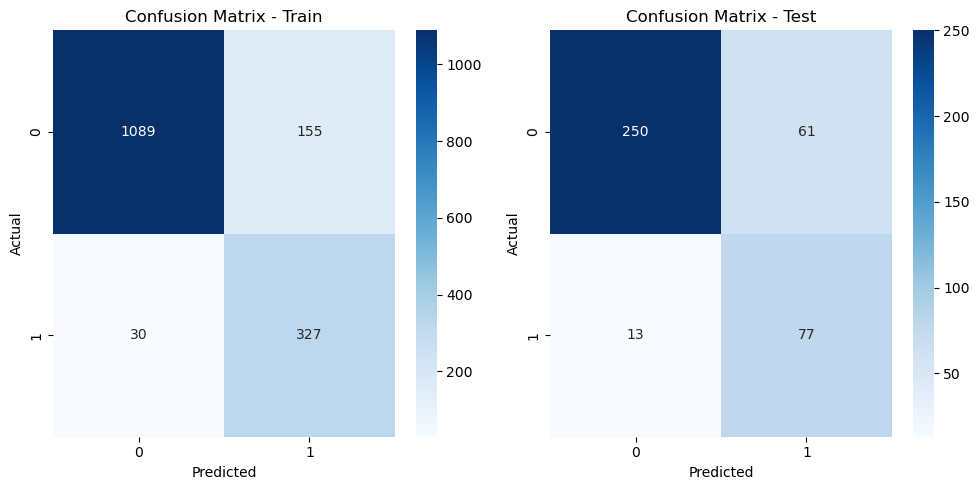

CV Score : Mean - 0.5346635 | Std - 0.06833706 | Min - 0.4225352 | Max - 0.6111111


RandomForestClassifier(max_depth=5)

In [23]:
modelfit(rf_model, X_train, y_train,X_test,y_test)

In [24]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5)


Model Report Train
AUC Score : 0.968314
Accuracy : 0.9176
Precision : 0.884
Recall : 0.725490

Model Report Test
AUC Score : 0.895427
Accuracy : 0.8554
Precision : 0.7286
Recall : 0.566667


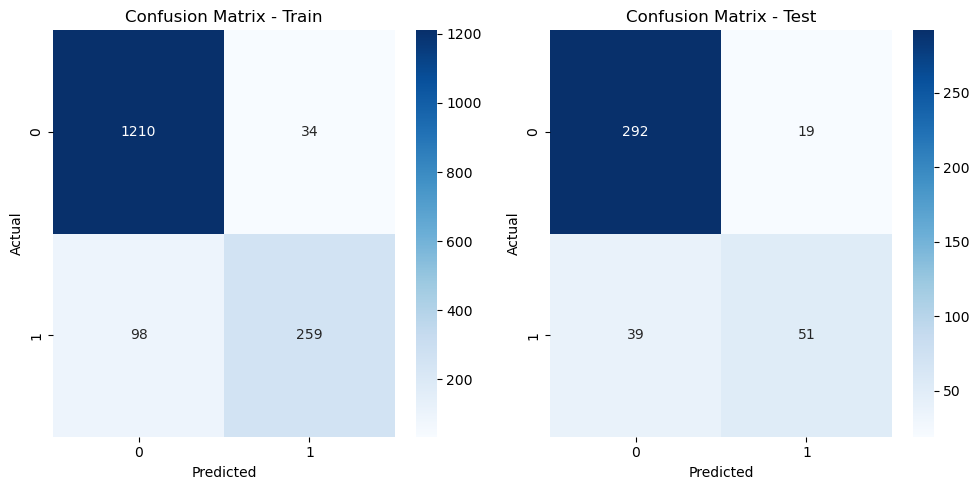

CV Score : Mean - 0.5264476 | Std - 0.03460427 | Min - 0.4647887 | Max - 0.5694444


RandomForestClassifier(max_depth=5)

[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   8.8s
[CV] END bootstrap=False, max_depth=40, max_features=log2, min_samples_leaf=1, min_samples_split=10, n_estimators=400; total time=   8.9s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  22.6s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  22.3s
[CV] END bootstrap=False, max_depth=10, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=  22.2s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 2.2min
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=4, min_samples_split=10, n_estimators=400; total time= 2.0min
[CV] END bootstrap=False, max_dept

In [25]:
modelfit(rf_model, X_train, y_train,X_test,y_test)